In [195]:
import pandas as pd
import pymatgen
from io import StringIO
import requests
from IPython.display import display
from scipy import stats
import numpy as np
from pprint import pprint
from pymatgen.ext.matproj import MPRester
import seaborn as sns
import matplotlib.pyplot as plt
from pymatgen.core.composition import Composition
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
import itertools as it
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, \
    GradientBoostingClassifier, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import export_text, export_graphviz
from sklearn.model_selection import cross_val_score
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import BSplines
import statsmodels.api as sm
import xgboost

# Today, we are analyzing a list of materials and attempting to predict their total poly dielectrtic constant. In the above, we import the necessary packages to analyze and manipulate data and we also import a variety of machine learning models to help us make our predictions 

In [196]:
#importng datasets
test = pd.read_csv(f'test.csv', na_filter = False)
train = pd.read_csv(f'train.csv', na_filter = False)

In [197]:
#setting readability options for dataframes. We will be looking at many features and will review them all
pd.set_option("display.max_columns", None)

In [198]:
#seeing how many features there are when using MPRester
with MPRester("DBpmfOPAI0rcze9C") as m:
    example = m.get_data(train["material_id"][0])
list_feature = [i for i in example[0]]
#list_feature

['energy',
 'energy_per_atom',
 'volume',
 'formation_energy_per_atom',
 'nsites',
 'unit_cell_formula',
 'pretty_formula',
 'is_hubbard',
 'elements',
 'nelements',
 'e_above_hull',
 'hubbards',
 'is_compatible',
 'spacegroup',
 'task_ids',
 'band_gap',
 'density',
 'icsd_id',
 'icsd_ids',
 'cif',
 'total_magnetization',
 'material_id',
 'oxide_type',
 'tags',
 'elasticity',
 'piezo',
 'diel',
 'deprecated',
 'full_formula']

In [199]:
#Queueing compound data from MPRester. 
with MPRester("DBpmfOPAI0rcze9C") as m:
    train_data = m.query(criteria={"task_id":{"$in":list(train["material_id"])}}, properties =list_feature)
    test_data = m.query(criteria={"task_id":{"$in":list(test["material_id"])}}, properties =list_feature)
    #flatten_data = [data[i][0] for i in range(len(data))]
    #get_data_test = pd.DataFrame(flatten_data)
    train_data

  0%|          | 0/5619 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

In [200]:
#Combining initial datasets with compound data 
train_df= pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df = train_df.merge(train, left_on ="material_id", right_on = "material_id")
test_df = test_df.merge(test, left_on ="material_id", right_on = "material_id")



In [201]:
#Create element database
unique=set()
elements=[]
material_list = list(train_df["pretty_formula"].map(Composition)) +list(test_df["pretty_formula"].map(Composition))
for i in material_list:
    for g in i:
        if not g in unique:
            unique.add(g)
            elements.append(g)
element_data = pd.DataFrame([i.data for i in elements])
element_data["Symbol"] = [i.symbol for i in elements]

In [440]:
element_data

,Atomic mass,Atomic no,Atomic orbitals,Atomic radius,Atomic radius calculated,Boiling point,Brinell hardness,Bulk modulus,Coefficient of linear thermal expansion,Common oxidation states,Critical temperature,Density of solid,Electrical resistivity,Electronic structure,ICSD oxidation states,Ionic radii,Liquid range,Melting point,Mendeleev no,Mineral hardness,Molar volume,Name,Oxidation states,Poissons ratio,Reflectivity,Refractive index,Rigidity modulus,Shannon radii,Superconduction temperature,Thermal conductivity,Van der waals radius,Velocity of sound,Vickers hardness,X,Youngs modulus,NMR Quadrupole Moment,Metallic radius,iupac_ordering,IUPAC ordering,Ground level,Ionization energies,Electron affinity,Ionic radii hs,Ionic radii ls,Max oxidation state,Min oxidation state,Symbol
0,24.30500,12,"{'1s': -45.973167, '2p': -1.71897, '2s': -2.90...",1.5,1.45,1363 K,260 MN m<sup>-2</sup>,45 GPa,8.2 x10<sup>-6</sup>K<sup>-1</sup>,[2],no data K,1738 kg m<sup>-3</sup>,4.4 10<sup>-8</sup> &Omega; m,[Ne].3s<sup>2</sup>,[2],{'2': 0.86},440 K,923 K,73,2.5,14.00 cm<sup>3</sup>,Magnesium,"[1, 2]",0.29,74 %,no data,17 GPa,"{'2': {'IV': {'': {'crystal_radius': 0.71, 'io...",no data K,160 W m<sup>-1</sup> K<sup>-1</sup>,1.73,4602 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,1.31,45 GPa,{'Mg-25': 199.4},1.6,16,16,1S0,"[7.646236, 15.035271, 80.1436, 109.2654, 141.3...",-0.420000,NaN,NaN,NaN,NaN,Mg
1,114.81800,49,"{'1s': -983.647445, '2p': -134.628845, '2s': -...",1.55,1.56,2345 K,8.83 MN m<sup>-2</sup>,no data GPa,32.1 x10<sup>-6</sup>K<sup>-1</sup>,[3],no data K,7310 kg m<sup>-3</sup>,8 10<sup>-8</sup> &Omega; m,[Kr].4d<sup>10</sup>.5s<sup>2</sup>.5p<sup>1</...,"[1, 2, 3]",{'3': 0.94},1915.25 K,429.75 K,79,1.2,15.76 cm<sup>3</sup>,Indium,"[1, 2, 3]",no data,no data %,no data,no data GPa,"{'3': {'IV': {'': {'crystal_radius': 0.76, 'io...",3.41 K,82 W m<sup>-1</sup> K<sup>-1</sup>,1.93,1215 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,1.78,11 GPa,"{'In-113': 759.8, 'In-115': 770.8}",1.67,78,78,2P°1/2,"[5.7863557, 18.87041, 28.04415, 55.45, 69.3, 9...",0.383926,NaN,NaN,NaN,NaN,In
2,78.96000,34,"{'1s': -451.300258, '2p': -51.514388, '2s': -5...",1.15,1.03,958 K,736 MN m<sup>-2</sup>,8.3 GPa,no data x10<sup>-6</sup>K<sup>-1</sup>,"[-2, 2, 4, 6]",1766 K,4819 kg m<sup>-3</sup>,high 10<sup>-8</sup> &Omega; m,[Ar].3d<sup>10</sup>.4s<sup>2</sup>.4p<sup>4</...,"[-1, 4, -2, 6]","{'-2': 1.84, '4': 0.64, '6': 0.56}",464 K,494 K,93,2.0,16.42 cm<sup>3</sup>,Selenium,"[-2, 2, 4, 6]",0.33,no data %,1.000895,3.7 GPa,"{'-2': {'VI': {'': {'crystal_radius': 1.84, 'i...",no data K,0.52 W m<sup>-1</sup> K<sup>-1</sup>,1.90,3350 m s<sup>-1</sup>,no data MN m<sup>-2</sup>,2.55,10 GPa,NaN,no data,95,95,3P2,"[9.752392, 21.196, 31.697, 42.947, 68.3, 81.83...",2.020605,NaN,NaN,NaN,NaN,Se
3,174.96700,71,"{'1s': -2146.885351, '2p': -334.330902, '2s': ...",1.75,2.17,3675 K,893 MN m<sup>-2</sup>,48 GPa,9.9 x10<sup>-6</sup>K<sup>-1</sup>,[3],no data K,9841 kg m<sup>-3</sup>,58 10<sup>-8</sup> &Omega; m,[Xe].4f<sup>14</sup>.5d<sup>1</sup>.6s<sup>2</...,[3],{'3': 1.001},1750 K,1925 K,20,no data,17.78 cm<sup>3</sup>,Lutetium,[3],0.26,no data %,no data,27 GPa,"{'3': {'VI': {'': {'crystal_radius': 1.001, 'i...",0.022 K,16 W m<sup>-1</sup> K<sup>-1</sup>,2.24,no data m s<sup>-1</sup>,1160 MN m<sup>-2</sup>,1.27,69 GPa,NaN,1.735,33,33,2D3/2,"[5.425871, 14.13, 20.9594, 45.249, 66.8, 98.0,...",0.238870,NaN,NaN,NaN,NaN,Lu
4,63.54600,29,"{'1s': -320.78852, '2p': -33.481247, '2s': -38...",1.35,1.45,3200 K,874 MN m<sup>-2</sup>,140 GPa,16.5 x10<sup>-6</sup>K<sup>-1</sup>,[2],no data K,8920 kg m<sup>-3</sup>,1.72 10<sup>-8</sup> &Omega; m,[Ar].3d<sup>10</sup>.4s<sup>1</sup>,"[1, 2, 3]","{'1': 0.91, '2': 0.87, '3': 0.68}",1842.23 K,1357.77 K,72,3.0,7.11 cm<sup>3</sup>,Copper,"[1, 2, 3, 4]",0.34,90 %,no data,48 GPa,"{'1': {'II': {'': {'crystal_radius': 0.6, 'ion...",no data K,400 W m<sup>-1</sup> K<sup>-1</sup>,1.96,3570 m s<sup>-1</sup>,369 MN m<sup>-2</sup>,1.90,130 GPa,"{'Cu-63': -220.15, 'Cu-65': -


We extract data from the elements dataframe and ignore data that cannot be easily parsed.

In [202]:
#feature extraction from element_data. 
new_element_data = element_data.iloc[:, [0,1,3,4,5,6,7,8,10,11,12,16,17,18,19,20,24,25,26, 28,29,30,34,36,41,46]]
new_element_data
for i in new_element_data.columns[:-1]:
    if type(new_element_data[i][0]) ==str and i!= "Symbol":
        new_element_data[i] = new_element_data[i].str.extract('(\d+)').astype(float)
    mean = np.mean(new_element_data[i].replace(['no data'], 0))
    new_element_data[i] = new_element_data[i].replace(['no data'], mean)
#drop na
new_element_data = new_element_data.dropna(axis =1)

#match 

C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/402639588.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_element_data[i] = new_element_data[i].replace(['no data'], mean)
C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/402639588.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_element_data[i] = new_element_data[i].str.extract('(\d+)').astype(float)


In [204]:
#Merging our compound dataset with elemental data
merged_material_test = test.merge(test_df,left_on = "material_id" , right_on = "material_id")
merged_material_train = train.merge(train_df,left_on = "material_id" , right_on = "material_id")

In [205]:
#Adding necessary columns for queueing data and dropping value related to DFT for the training data. 
final_train = merged_material_train.select_dtypes(include=[float, int])
final_train["unit_cell_formula"] = merged_material_train["unit_cell_formula"]
final_train["pretty_formula"] = merged_material_train["pretty_formula"]
final_train["material_id"] = merged_material_train["material_id"]
final_train = final_train.drop(["energy","energy_per_atom","formation_energy_per_atom", "band_gap", "e_above_hull", "dielectric_poly_total_y"], axis =1)

C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/759728135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train["unit_cell_formula"] = merged_material_train["unit_cell_formula"]
C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/759728135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train["pretty_formula"] = merged_material_train["pretty_formula"]
C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/759728135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [206]:
#Repeat process with test data
final_test = merged_material_test.select_dtypes(include=[float, int])
final_test["unit_cell_formula"] = merged_material_test["unit_cell_formula"]
final_test["pretty_formula"] = merged_material_test["pretty_formula"]
final_test["material_id"] = merged_material_test["material_id"]
final_test= final_test.drop(["energy","energy_per_atom","formation_energy_per_atom", "band_gap", "e_above_hull"], axis =1)

C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/2160991009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test["unit_cell_formula"] = merged_material_test["unit_cell_formula"]
C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/2160991009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test["pretty_formula"] = merged_material_test["pretty_formula"]
C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/2160991009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [207]:
nele_columns = new_element_data.columns


# We want to process the elemental data in a way that accounts for the compound we are trying to analyze. We will take the min, max, and weighted mean of the element properties and featurize our dataframe with them. 

In [ ]:
#Computing the max, min, and average of elemental data for training data. 
a = final_train["unit_cell_formula"]
for b in nele_columns[:-1]:
    minn = []
    maxx = []
    avg = []
    for i in range(len(a)):
        i_avg= []
        i_lst = []
        for c in a[i]:
            i_avg.append(a[i][c] * float(new_element_data.loc[new_element_data["Symbol"] == c][b]))
            i_lst.append(float(new_element_data.loc[new_element_data["Symbol"] == c][b]))
            
        minn.append(min(i_lst))
        maxx.append(max(i_lst))
        avg.append(np.mean(i_avg))
    final_train[b +"_min"] = minn
    final_train[b +"_max"] = maxx
    final_train[b +"_avg"] = avg
    

In [88]:
#Getting composition for data queueing
final_train["Composition"] = final_train["pretty_formula"].apply(Composition)
final_test["Composition"] = final_test["pretty_formula"].apply(Composition)                                       

In [89]:
final_train.to_csv("train_ele_data")

In [90]:
#Computing max, min, and average for test data
a = final_test["unit_cell_formula"]
for b in nele_columns[:-1]:
    minn = []
    maxx = []
    avg = []
    for i in range(len(a)):
        i_avg= []
        i_lst = []
        for c in a[i]:
            i_avg.append(a[i][c] * float(new_element_data.loc[new_element_data["Symbol"] == c][b]))
            i_lst.append(float(new_element_data.loc[new_element_data["Symbol"] == c][b]))
            
        minn.append(min(i_lst))
        maxx.append(max(i_lst))
        avg.append(np.mean(i_avg))
    final_test[b +"_min"] = minn
    final_test[b +"_max"] = maxx
    final_test[b +"_avg"] = avg

#
Below, we analyze the features of our dataframe and visualize which features are most correlated to the dielectric_poly_total. We observe that the density, atomic mass, and atomic number are significant features with density being the most correlated with the dielectric polycrystalline total. Below are the correlation coefficients and an equivalent heatmap. From here, we decided to obtain density features to explore their signifance even further. Currently, it implies that the spacing between atoms, their size, and their number of ions are factors in the dielectric constant. This makes sense as the polariziability of material is known to affect the dielectric constant

In [92]:
final_train.corr()

,dielectric_poly_total_x,volume,nsites,nelements,density,total_magnetization,Atomic mass_min,Atomic mass_max,Atomic mass_avg,Atomic no_min,Atomic no_max,Atomic no_avg,Atomic radius_min,Atomic radius_max,Atomic radius_avg,Atomic radius calculated_min,Atomic radius calculated_max,Atomic radius calculated_avg,Boiling point_min,Boiling point_max,Boiling point_avg,Brinell hardness_min,Brinell hardness_max,Brinell hardness_avg,Coefficient of linear thermal expansion_min,Coefficient of linear thermal expansion_max,Coefficient of linear thermal expansion_avg,Density of solid_min,Density of solid_max,Density of solid_avg,Electrical resistivity_min,Electrical resistivity_max,Electrical resistivity_avg,Liquid range_min,Liquid range_max,Liquid range_avg,Melting point_min,Melting point_max,Melting point_avg,Mendeleev no_min,Mendeleev no_max,Mendeleev no_avg,Molar volume_min,Molar volume_max,Molar volume_avg,Thermal conductivity_min,Thermal conductivity_max,Thermal conductivity_avg,Van der waals radius_min,Van der waals radius_max,Van der waals radius_avg,Metallic radius_min,Metallic radius_max,Metallic radius_avg,Electron affinity_min,Electron affinity_max,Electron affinity_avg
dielectric_poly_total_x,1.000000,-0.050360,-0.070327,-0.030243,0.472502,-0.028308,0.177701,0.317296,0.179771,0.181479,0.317696,0.165455,0.192673,0.056031,0.019795,0.180410,0.054335,0.025845,0.230226,0.164886,0.124346,0.114272,0.151526,0.161250,-0.020805,-0.018966,-0.034370,0.230095,0.226919,0.230198,0.012101,-0.043581,-0.002243,0.232373,0.225110,0.137864,0.213883,0.077997,0.103380,0.013588,-0.225961,-0.086225,0.098777,-0.066908,-0.051857,0.135214,-0.051414,-0.010561,0.213238,-0.008022,-0.026232,0.076359,0.002586,-0.046503,0.003763,-0.148682,-0.148220
volume,-0.050360,1.000000,0.759142,0.105855,-0.099569,-0.051378,0.158155,0.075216,0.781203,0.164044,0.076179,0.805542,0.184204,0.151151,0.860015,0.169001,0.134200,0.838146,0.037613,-0.006446,0.616649,-0.057562,0.006160,0.361674,-0.042199,-0.032092,0.528793,0.047747,0.005666,0.575321,-0.021458,0.092780,0.215611,0.024895,0.010631,0.602136,0.060889,-0.015541,0.582059,-0.072621,-0.109757,0.692464,0.111541,0.174988,0.866184,-0.011626,-0.034447,0.472330,0.169160,0.161132,0.834118,-0.036352,0.157733,0.807321,0.035591,0.038164,0.581023
nsites,-0.070327,0.759142,1.000000,0.287461,-0.164335,0.017865,-0.214861,-0.128080,0.494312,-0.221650,-0.129187,0.531293,-0.238866,-0.086942,0.803391,-0.221821,-0.072430,0.801840,-0.206933,0.082836,0.655858,-0.096059,-0.000594,0.307629,-0.170126,0.063195,0.696711,-0.186474,-0.051762,0.421577,-0.022929,0.137695,0.229986,-0.189632,0.018563,0.635592,-0.190456,0.111701,0.618020,-0.042756,0.209124,0.878925,-0.131844,-0.073745,0.817105,-0.074421,-0.045081,0.532976,-0.233151,-0.081943,0.885717,-0.045810,-0.067142,0.911125,-0.066624,-0.118724,0.518126
nelements,-0.030243,0.105855,0.287461,1.000000,-0.060820,0.101935,-0.297890,0.055440,-0.178230,-0.307565,0.058949,-0.176803,-0.304465,0.221878,-0.090762,-0.293286,0.229765,-0.082181,-0.254370,0.220999,-0.108213,-0.137047,0.074678,-0.117829,-0.165016,0.226919,0.010075,-0.238890,0.084971,-0.169109,-0.070828,0.075361,-0.102480,-0.211913,0.194172,-0.099213,-0.284990,0.230433,-0.111090,-0.348425,0.277241,-0.030682,-0.294013,0.146726,-0.038770,-0.176606,0.181727,-0.054880,-0.298219,0.170783,-0.062105,-0.084550,0.200671,-0.033301,-0.253251,0.040135,-0.084339
density,0.472502,-0.099569,-0.164335,-0.060820,1.000000,-0.048443,0.357007,0.720355,0.352905,0.363836,0.722908,0.319848,0.275747,0.108980,-0.032303,0.215794,0.139535,-0.032068,0.285820,0.290317,0.117658,0.201296,0.349853,0.291598,-0.011770,-0.080402,-0.134017,0.364049,0.616545,0.431258,-0.014777,-0.076308,-0.048798,0.310137,0.384878,0.139205,0.242820,0.143065,0.089711,0.090823,-0.244126,-0.153882,0.072702,-0.060954,-0.122644,0.078827,0.058709,-0.032298,0.320840,0.058338,-0.094419,0.064509,-0.001272,-0.133619,0.008529,-0.077096,-0.159869
total_magnetization,-0.028308,-0.051378,0.017865,0.101935,-0.048443,1.0000

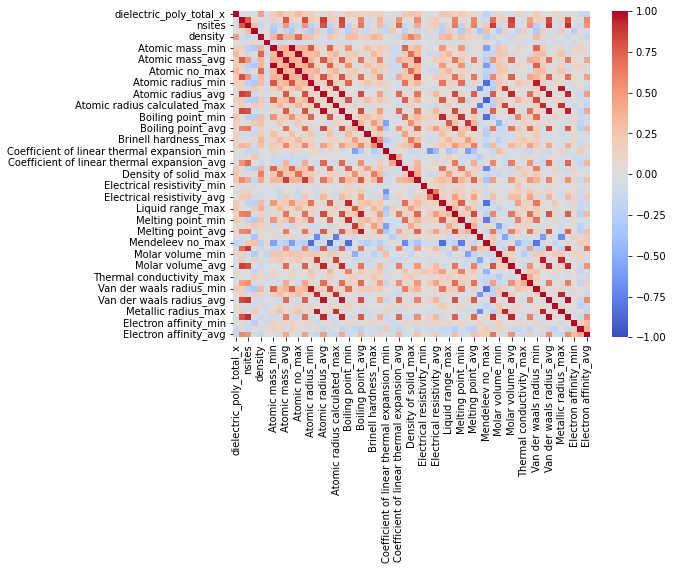

In [93]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(final_train.corr(), cmap="coolwarm", vmin=-1, vmax=1, ax=ax);

In [94]:
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.conversions import CompositionToStructureFromMP
from pymatgen.core import Composition


In [95]:
#Obtaining composition and structural data from 
scdf = CompositionToStructureFromMP(mapi_key = "DBpmfOPAI0rcze9C")


comp_train = []
comp_test=[]
for i in final_train["pretty_formula"]:
    h =Composition(i)
    comp_train.append(h)
for i in final_test["pretty_formula"]:
    h =Composition(i)
    comp_test.append(h)

final_train["Composition"] = comp_train
final_test["Composition"] = comp_test
final_test = scdf.featurize_dataframe(final_test, "Composition")
final_train = scdf.featurize_dataframe(final_train, "Composition")


CompositionToStructureFromMP:   0%|          | 0/1400 [00:00<?, ?it/s]

CompositionToStructureFromMP:   0%|          | 0/5619 [00:00<?, ?it/s]

In [96]:
final_test = final_test.rename(columns= {"density": "density_MPR"})
final_train = final_train.rename(columns= {"density": "density_MPR"})


In [97]:
final_test.to_csv("final_test.csv")
final_train.to_csv("final_train.csv")

In [423]:
final_train

,dielectric_poly_total_x,volume,nsites,nelements,density_MPR,total_magnetization,unit_cell_formula,pretty_formula,material_id,Atomic mass_min,Atomic mass_max,Atomic mass_avg,Atomic no_min,Atomic no_max,Atomic no_avg,Atomic radius_min,Atomic radius_max,Atomic radius_avg,Atomic radius calculated_min,Atomic radius calculated_max,Atomic radius calculated_avg,Boiling point_min,Boiling point_max,Boiling point_avg,Brinell hardness_min,Brinell hardness_max,Brinell hardness_avg,Coefficient of linear thermal expansion_min,Coefficient of linear thermal expansion_max,Coefficient of linear thermal expansion_avg,Density of solid_min,Density of solid_max,Density of solid_avg,Electrical resistivity_min,Electrical resistivity_max,Electrical resistivity_avg,Liquid range_min,Liquid range_max,Liquid range_avg,Melting point_min,Melting point_max,Melting point_avg,Mendeleev no_min,Mendeleev no_max,Mendeleev no_avg,Molar volume_min,Molar volume_max,Molar volume_avg,Thermal conductivity_min,Thermal conductivity_max,Thermal conductivity_avg,Van der waals radius_min,Van der waals radius_max,Van der waals radius_avg,Metallic radius_min,Metallic radius_max,Metallic radius_avg,Electron affinity_min,Electron affinity_max,Electron affinity_avg,Composition,structure,density,vpa,packing fraction
0,8.337936,383.846214,26,3,4.773276,2.280000e-05,"{'Al': 2.0, 'I': 6.0, 'O': 18.0}",Al(IO3)3,mp-555903,15.99940,126.904470,367.793032,8.0,53.0,162.666667,0.60,1.40,7.233333,0.48,1.18,5.966667,90.0,2792.0,3315.333333,2.0,245.0,179.333333,10.0,23.0,95.333333,3.0,4940.0,11698.000000,2.0,10.0,81.333333,35.0,1858.0,1588.666667,54.0,933.0,1718.000000,80.0,101.0,853.333333,10.0,25.0,158.666667,0.0,235.0,156.666667,1.52,1.98,14.306667,1.322111,1.430,11.530222,0.432835,3.059052,15.173293,"(Al, I, O)","[[4.554065 2.62929593 0.4441569 ] Al, [ 4.55...",4.773276,14.763316,0.264722
1,14.735277,88.364324,5,3,5.426564,2.870000e-05,"{'Y': 2.0, 'Se': 1.0, 'O': 2.0}",Y2SeO2,mp-752658,15.99940,88.905850,96.256833,8.0,39.0,42.666667,0.60,1.80,1.983333,0.48,2.12,2.076667,90.0,3609.0,2785.333333,2.0,736.0,639.333333,10.0,10.0,16.666667,3.0,4819.0,4589.666667,10.0,60.0,50.000000,35.0,1810.0,1384.666667,54.0,1799.0,1400.000000,25.0,101.0,115.000000,16.0,19.0,29.333333,0.0,17.0,11.333333,1.52,2.32,3.193333,1.322111,1.800,2.522111,0.307120,2.020605,1.852352,"(Y, Se, O)","[[1.928942 1.11367756 1.99281086] Y, [ 1.928...",5.426564,17.672865,0.645489
2,17.195305,176.254455,12,3,4.083765,0.000000e+00,"{'Sb': 2.0, 'P': 2.0, 'O': 8.0}",SbPO4,mp-3439,15.99940,121.760000,144.487575,8.0,51.0,65.333333,0.60,1.45,3.233333,0.48,1.33,2.820000,90.0,1860.0,1846.666667,2.0,294.0,202.666667,10.0,11.0,40.666667,3.0,6697.0,5688.000000,10.0,40.0,60.000000,35.0,956.0,885.333333,54.0,903.0,957.333333,88.0,101.0,388.000000,17.0,18.0,68.666667,0.0,24.0,16.000000,1.52,2.06,6.626667,1.322111,1.610,5.480370,0.746607,1.461105,5.092286,"(Sb, P, O)","[[5.163675 1.42442784 4.24615709] Sb, [1.721...",4.083765,14.687871,0.233503
3,21.593507,747.849954,44,4,6.254285,2.116000e-04,"{'Sm': 12.0, 'Nb': 4.0, 'S': 12.0, 'O': 16.0}",Sm3NbS3O4,mp-16135,15.99940,150.360000,704.178980,8.0,62.0,307.000000,0.60,1.85,12.400000,0.48,2.38,13.680000,90.0,5017.0,13756.000000,2.0,736.0,2073.000000,7.0,12.0,113.000000,3.0,8570.0,36521.000000,10.0,94.0,367.000000,35.0,2267.0,5587.000000,54.0,2750.0,8165.000000,28.0,101.0,823.000000,10.0,19.0,180.000000,0.0,54.0,93.000000,1.52,2.36,20.740000,1.322111,1.804,16.139778,0.162000,2.077105,13.479142,"(Sm, Nb, S, O)","[[ 4.91173781 3.82520434 11.93864906] Sm, [1....",6.254285,16.996590,0.580443
4,9.507068,273.897924,28,3,4.289761,1.750000e-07,"{'Al': 8.0, 'Co': 4.0, 'O': 16.0}",Al2CoO4,mp-36447,15.99940,58.933195,235.858496,8.0,27.0,113.333333,0.60,1.35,8.333333,0.48,1.52,7.733333,90.0,3200.0,12192.000000,2.0,700.0,1597.333333,10.0,23.0,132.000000,3.0,8900.0,19082.666667,2.0,10.0,66.666667,35.0,1858.0,7050.666667,54.0,1768.0,5133.333333,64.0,101.0,837.333333,6.0,17.0,125.333333,0.0,235.0,760.000000,1.52,2.

In [106]:
#From our correlation matrix, we decide to gather more data on the density features such as the VPA and the packing density

densitydf = DensityFeatures()

final_test_= densitydf.featurize_dataframe(final_test, "structure",ignore_errors=True)
final_train_ = densitydf.featurize_dataframe(final_train, "structure", ignore_errors=True)

DensityFeatures:   0%|          | 0/1400 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/5619 [00:00<?, ?it/s]

# In our visualizations of the density features and the total poly dielectric constant, we note that there are similar distributions between them. 


Text(0, 0.5, 'Count')

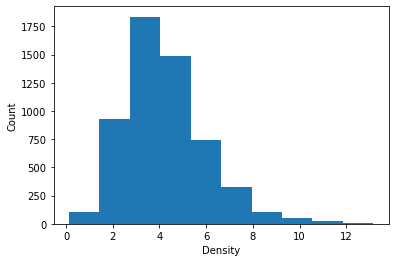

In [419]:
plt.hist(final_train["density"])
plt.xlabel("Density")
plt.ylabel("Count")

Text(0, 0.5, 'count')

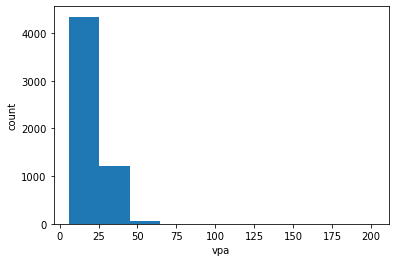

In [421]:
plt.hist(final_train["vpa"])
plt.xlabel("vpa")
plt.ylabel("count")


Text(0, 0.5, 'count')

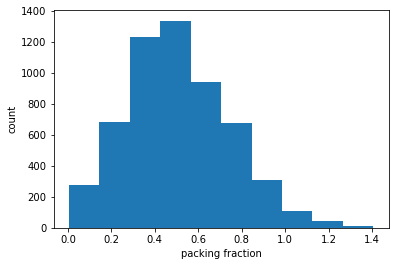

In [422]:
plt.hist(final_train["packing fraction"])
plt.xlabel("packing fraction")
plt.ylabel("count")


Text(0, 0.5, 'count')

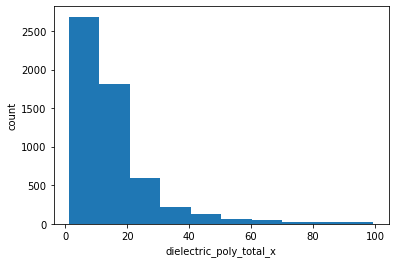

In [424]:
plt.hist(final_train["dielectric_poly_total_x"])
plt.xlabel("dielectric_poly_total_x")
plt.ylabel("count")



In [109]:
final_test_.to_csv("final_test.csv")
final_train_.to_csv("final_train.csv")

In [110]:
final_test_

,volume,nsites,nelements,density_MPR,total_magnetization,unit_cell_formula,pretty_formula,material_id,Composition,Atomic mass_min,Atomic mass_max,Atomic mass_avg,Atomic no_min,Atomic no_max,Atomic no_avg,Atomic radius_min,Atomic radius_max,Atomic radius_avg,Atomic radius calculated_min,Atomic radius calculated_max,Atomic radius calculated_avg,Boiling point_min,Boiling point_max,Boiling point_avg,Brinell hardness_min,Brinell hardness_max,Brinell hardness_avg,Coefficient of linear thermal expansion_min,Coefficient of linear thermal expansion_max,Coefficient of linear thermal expansion_avg,Density of solid_min,Density of solid_max,Density of solid_avg,Electrical resistivity_min,Electrical resistivity_max,Electrical resistivity_avg,Liquid range_min,Liquid range_max,Liquid range_avg,Melting point_min,Melting point_max,Melting point_avg,Mendeleev no_min,Mendeleev no_max,Mendeleev no_avg,Molar volume_min,Molar volume_max,Molar volume_avg,Thermal conductivity_min,Thermal conductivity_max,Thermal conductivity_avg,Van der waals radius_min,Van der waals radius_max,Van der waals radius_avg,Metallic radius_min,Metallic radius_max,Metallic radius_avg,Electron affinity_min,Electron affinity_max,Electron affinity_avg,structure,density,vpa,packing fraction
0,192.921902,7,4,5.260498,8.000000e-07,"{'In': 1.0, 'Ag': 1.0, 'Ge': 1.0, 'Se': 4.0}",InAgGeSe4,mp-1223893,"(In, Ag, Ge, Se)",72.640000,114.81800,152.791550,32.0,49.0,66.000000,1.15,1.60,2.250000,1.03,1.65,2.145000,958.0,3093.0,2926.250000,2.0,736.0,744.500000,6.0,32.0,24.000000,4819.0,10490.0,10599.750000,1.0,50000.0,12512.250000,464.0,1915.0,1713.000000,429.0,1234.0,1212.500000,71.0,93.0,151.500000,10.0,16.0,25.500000,0.0,430.0,143.000000,1.90,2.11,3.437500,1.322111,1.670000,2.448361,0.383926,2.020605,2.750874,"[[0. 0. 5.568691] In, [2.942959 0...",5.260498,27.560272,0.344282
1,543.884152,24,4,4.228700,1.160440e-02,"{'Sr': 3.0, 'Cu': 6.0, 'Sn': 3.0, 'S': 12.0}",SrCu2SnS4,mp-16988,"(Sr, Cu, Sn, S)",32.065000,118.71000,346.261500,16.0,50.0,157.500000,1.00,2.00,7.612500,0.88,2.19,7.545000,717.0,3200.0,10348.500000,2.0,874.0,1356.750000,10.0,22.0,87.000000,1960.0,8920.0,26715.000000,1.0,13.0,49.500000,329.0,2369.0,5980.500000,388.0,1357.0,4365.750000,15.0,94.0,463.500000,7.0,33.0,92.250000,0.0,400.0,676.500000,1.80,2.49,11.835000,1.278000,2.151000,8.681583,0.052066,2.077105,8.958092,"[[ 1.78666417 3.0945929 12.9912298 ] Sr, [ 1...",4.228682,22.661939,0.461388
2,190.583786,12,2,8.957968,6.950000e-06,"{'P': 8.0, 'Pt': 4.0}",P2Pt,mp-730,"(P, Pt)",30.973762,195.08400,514.063048,15.0,78.0,216.000000,1.00,1.35,6.700000,0.98,1.77,7.460000,550.0,4098.0,10396.000000,2.0,392.0,792.000000,8.0,10.0,56.000000,1823.0,21090.0,49472.000000,10.0,10.0,60.000000,232.0,2056.0,5040.000000,317.0,2041.0,5350.000000,68.0,90.0,496.000000,9.0,17.0,86.000000,0.0,72.0,144.000000,1.80,2.13,11.460000,1.322111,1.387000,8.062444,0.746607,2.125105,7.236638,"[[2.24416239 2.24416239 2.24416239] P, [0.6332...",8.957968,15.881982,0.392134
3,839.325168,18,3,4.446308,3.631000e-04,"{'Ba': 4.0, 'Sr': 2.0, 'I': 12.0}",Ba2SrI6,mp-756202,"(Ba, Sr, I)",87.620000,137.32700,749.133880,38.0,56.0,312.000000,1.40,2.15,9.800000,1.15,2.53,9.433333,457.0,2143.0,5788.666667,2.0,2.0,12.000000,10.0,22.0,81.333333,2630.0,4940.0,26193.333333,10.0,34.0,94.000000,70.0,1143.0,2207.333333,386.0,1050.0,3577.333333,14.0,97.0,416.666667,25.0,38.0,172.666667,0.0,35.0,47.333333,1.98,2.68,13.153333,1.322111,2.236000,9.703778,0.052066,3.059052,12.463755,"[[0. 4.1486395 4.11204013] Ba, [0. ...",4.354529,47.611964,0.433444
4,294.954427,8,2,5.286907,4.025000e-06,"{'Ag': 4.0, 'I': 4.0}",AgI,mp-580941,"(Ag, I)",107.868200,126.90447,469.545340,47.0,53.0,200.000000,1.40,1.60,6.000000,1.15,1.65,5.600000,457.0,2435.0,5784.000000,2.0,24.0,52.000000,10.0,18.0,56.000000,4940.0,10490.0,30860.000000,1.0,10.0,22.000000,70.0,1200.0,2540.000000,386.0,1234.0,3240.000000,71.0,97.0,336.000000,10.0,25.0,70.000000,0.0,430.0,860.000000,1.98,2.11,8.180000,1.322111,1.445000,5.534222,1.

In [111]:
#There were 6 material_ids that contained "no data or NaN". We replaced those values with the mean of the column in order to
#process the data in our machine learning methods 
final_test_[final_test_.isna().any(axis=1)]
final_train_[final_train_.isna().any(axis=1)]
for i in densitydf.feature_labels():
    final_test_[i]=final_test_[i].replace(np.nan, np.mean(final_test_[i]))
    final_train_[i] = final_train_[i].replace(np.nan, np.mean(final_train_[i]))

In [262]:
final_test = final_test_
final_train= final_train_

In [441]:
#We are splitting our training data for evaluating and training our models. We elected to do a standard 90:10 split on
# training and test data.
X = final_train.loc[:, ~final_train.columns.isin(["dielectric_poly_total_x", "unit_cell_formula", "pretty_formula", "material_id","structure", "Composition"])]
Y = final_train[["dielectric_poly_total_x"]]
Kaggle_X = final_test.loc[:, ~final_test.columns.isin(["unit_cell_formula", "pretty_formula", "material_id", "structure","Composition"])]
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.1)

In [357]:
def plot_grid_search_results(gs, ylim=None):
    """
    Plots the results of GridSearchCV.
    
    Args:
        gs: A GridSearchCV object.
        ylim: Optional setting for y limits.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))    
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker='x')
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker='o')
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    ax.legend(["Train", "Test"], loc=2);
    

#  Model evaluation: We will be using linear models and ensemble techniques. We will use our training data to train and fit them, and will evaluate their performance with Mean Absolute Error(MAE)

For our linear methods models, we scaled and transform our data points to have a standard dev of 1 and a mean of 0. In all our models, we cross-validate our results in order to obtain the closest to ideal model and obtain an MAE that is more representative of the model's performance. 

In [358]:
scaler = StandardScaler()
scaler.fit(train_X)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_train_X = scaler.transform(train_X)
norm_test_X = scaler.transform(test_X)
norm_kaggle_X = scaler.transform(Kaggle_X)

x_lin_train= norm_train_X
y_lin_train = train_y["dielectric_poly_total_x"]
x_lin_test = norm_test_X

y_lin_test = test_y["dielectric_poly_total_x"]
y_target = Y["dielectric_poly_total_x"]

# Linear Regression 


In [359]:
features = [c for c in X]
reg = linear_model.LinearRegression()
reg.fit(x_lin_train, y_lin_train)
r2 = reg.score(x_lin_train,y_lin_train)
equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
kfold = KFold(n_splits=5, shuffle=True)
DV_reg = cross_validate(reg,x_lin_train, y_lin_train, cv= kfold, return_estimator =True)
mae_reg = []
rmse_reg =[] 
for i in DV_reg["estimator"]:
    a = i.predict(x_lin_test)
    mae_reg.append(metrics.mean_absolute_error(a, y_lin_test))  
    rmse_reg.append(np.sqrt(metrics.mean_squared_error(a, y_lin_test)))
print(np.mean(mae_reg))
print(np.mean(rmse_reg))




6.704575057118587
11.633640660403142


# Ridge Regression

In [360]:
ridge = linear_model.Ridge(alpha=.1, max_iter =10000)
DV_ridge = cross_validate(ridge,x_lin_train, y_lin_train, cv= kfold, return_estimator =True )
mae_ridge = []
rmse_ridge = []
for i in DV_ridge["estimator"]:
    yhat_ridge = i.predict(x_lin_test)
    rmse_ridge.append(np.sqrt(metrics.mean_squared_error(y_lin_test, yhat_ridge)))
    mae_ridge.append(metrics.mean_absolute_error(y_lin_test, yhat_ridge))
    
print(np.mean(mae_ridge))
print(np.mean(rmse_ridge))


6.704817885313479
11.640411870476038


# Lasso Regression

In [361]:
lasso = linear_model.Lasso(alpha = .1, max_iter = 10000)
DV_lasso = cross_validate( lasso,x_lin_train, y_lin_train, cv= kfold, return_estimator = True )

mae_lasso = []
rmse_lasso = []
for i in DV_lasso["estimator"]:
    yhat_lasso = i.predict(x_lin_test)
    rmse_lasso.append(np.sqrt(metrics.mean_squared_error(y_lin_test, yhat_lasso)))
    mae_lasso.append(metrics.mean_absolute_error(y_lin_test, yhat_lasso))
    
print(np.mean(mae_lasso))
print(np.mean(rmse_lasso))


6.703594562330754
11.66660979541341


In [230]:
ltrain_X

,volume,nsites,nelements,density_MPR,total_magnetization,Atomic mass_min,Atomic mass_max,Atomic mass_avg,Atomic no_min,Atomic no_max,Atomic no_avg,Atomic radius_min,Atomic radius_max,Atomic radius_avg,Atomic radius calculated_min,Atomic radius calculated_max,Atomic radius calculated_avg,Boiling point_min,Boiling point_max,Boiling point_avg,Brinell hardness_min,Brinell hardness_max,Brinell hardness_avg,Coefficient of linear thermal expansion_min,Coefficient of linear thermal expansion_max,Coefficient of linear thermal expansion_avg,Density of solid_min,Density of solid_max,Density of solid_avg,Electrical resistivity_min,Electrical resistivity_max,Electrical resistivity_avg,Liquid range_min,Liquid range_max,Liquid range_avg,Melting point_min,Melting point_max,Melting point_avg,Mendeleev no_min,Mendeleev no_max,Mendeleev no_avg,Molar volume_min,Molar volume_max,Molar volume_avg,Thermal conductivity_min,Thermal conductivity_max,Thermal conductivity_avg,Van der waals radius_min,Van der waals radius_max,Van der waals radius_avg,Metallic radius_min,Metallic radius_max,Metallic radius_avg,Electron affinity_min,Electron affinity_max,Electron affinity_avg
5170,217.285369,16,4,5.704577,0.000000e+00,15.999400,107.868200,186.614250,8.0,47.0,85.000000,0.60,1.60,4.025000,0.48,1.65,3.875000,90.0,3173.0,4791.500000,2.0,412.0,235.000000,2.0,30.0,54.000000,3.0,10490.0,15231.000000,1.0,100000.0,50024.000000,35.0,1486.0,2256.500000,54.0,1687.0,2531.500000,71.0,101.0,353.500000,9.0,17.0,54.500000,0.0,430.0,565.000000,1.52,2.11,7.205000,1.322111,1.445,5.420278,-0.620000,1.461105,4.611444
3991,176.709799,8,3,4.542900,5.000000e-08,32.065000,107.868200,161.147467,16.0,47.0,73.333333,1.00,1.60,3.266667,0.88,1.65,3.180000,717.0,2477.0,4230.666667,2.0,60.0,58.666667,10.0,120.0,105.333333,1960.0,10490.0,13542.666667,1.0,14.0,23.333333,329.0,2174.0,2688.000000,302.0,1234.0,1541.333333,71.0,94.0,226.666667,10.0,15.0,34.000000,0.0,430.0,306.000000,1.80,2.11,5.053333,1.322111,1.445,3.626148,0.301201,2.077105,3.839922
3053,196.720600,11,5,3.697260,7.900000e-06,1.007940,183.840000,87.601332,1.0,74.0,39.200000,0.25,1.60,1.720000,0.53,1.93,1.956000,20.0,5828.0,2257.600000,2.0,2570.0,522.400000,4.0,18.0,22.400000,3.0,19250.0,7519.000000,1.0,10.0,19.200000,6.0,2133.0,937.400000,14.0,3695.0,1320.000000,55.0,103.0,202.800000,9.0,15.0,27.200000,0.0,430.0,120.000000,1.10,2.18,3.488000,1.322111,1.445,2.950800,-0.070000,2.077105,2.675510
1180,893.271814,22,3,2.974036,5.019704e+00,39.098300,127.600000,533.285230,19.0,52.0,231.333333,1.40,2.20,13.466667,1.23,2.43,14.073333,1032.0,2334.0,9046.666667,0.0,196.0,610.666667,10.0,21.0,80.666667,856.0,7470.0,25044.000000,7.0,10000.0,26790.666667,538.0,815.0,4758.000000,336.0,1519.0,4282.000000,10.0,92.0,325.333333,7.0,45.0,238.000000,3.0,100.0,412.666667,2.05,2.75,17.860000,1.292000,2.381,13.910963,-0.520000,1.970876,6.914838
4731,234.366092,15,3,6.802027,0.000000e+00,15.999400,196.966569,320.009446,8.0,79.0,137.333333,0.60,2.00,5.833333,0.48,2.19,6.090000,90.0,3129.0,5084.333333,2.0,2450.0,1642.000000,10.0,22.0,72.666667,3.0,19300.0,17258.000000,2.0,13.0,49.666667,35.0,1791.0,2295.666667,54.0,1337.0,2785.333333,15.0,101.0,341.000000,10.0,33.0,107.000000,0.0,320.0,271.666667,1.52,2.49,9.630000,1.322111,2.151,8.071963,0.052066,2.308610,5.522131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,492.746823,16,3,2.475676,0.000000e+00,32.065000,121.760000,244.876600,16.0,51.0,114.666667,1.00,2.20,8.033333,0.88,2.43,8.093333,717.0,1860.0,5216.000000,0.0,294.0,201.333333,10.0,11.0,54.000000,856.0,6697.0,11403.333333,7.0,40.0,67.333333,329.0,956.0,2904.666667,336.0,903.0,2308.666667,10.0,94.0,329.333333,15.0,45.0,142.000000,0.0,100.0,216.000000,1.80,2.75,11.673333,1.322111,2.381,9.360963,0.501459,2.077105,7.240131
2852,84.954798,6,3,2.393238,1.496000e-04,15.99

In [269]:

prediction_lasso = DV_lasso["estimator"][3].predict(Kaggle_X)
prediction_lassodf = pd.DataFrame( final_test["material_id"])
prediction_lassodf["dielectric_poly_total"] = prediction_lasso

# For our linear models, our lasso model has the lowest MAE at 6.60. However, our data's distribution and number of features make using simpler methods less ideal. We can take more complex models to predict our data and get more accurate results

In [270]:
prediction_lassodf
#prediction_lassodf
prediction_lassodf.to_csv("Prediction_lasso.csv", index=False)

# Random Forest Regression

I chose to utilize this model due to its adaptive nature in scaling when it comes to adding more features. Additionally, we can observe and rank the importance of variables using this method. Its high accuracy due to its ensemble approach is also something that will be helpful in predicting the total polycrystalline dielectric constant. 

In [362]:
RF_model = RandomForestRegressor(n_estimators=100)
CV_RF = cross_validate(RF_model, train_X, train_y, cv =kfold, return_estimator = True)
mae_rf = []
rmse_rf = []
for i in CV_RF["estimator"]: 
    yhat_rf = i.predict(test_X)
    rmse_rf.append(np.sqrt(metrics.mean_squared_error(test_y, yhat_rf)))
    mae_rf.append(metrics.mean_absolute_error(test_y, yhat_rf))

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pa

In [363]:
print(np.mean(mae_rf))
print(np.mean(rmse_rf))
mae_rf

5.9201260832449325
10.456863172819883


[5.891752133435088,
 5.930988518623844,
 5.898467640448666,
 5.907301785001566,
 5.972120338715499]

# We have significantly improved our MAE by using random forest regression. We have lowered the value by approximately 11.9%. As expected, ensemble techniques were more powerful than linear models. 

In [273]:
RF_model = CV_RF["estimator"][3].fit(train_X, train_y)


#print(model.feature_importances_)

C:\Users\Ryan\AppData\Local\Temp/ipykernel_38824/3056844419.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model = CV_RF["estimator"][3].fit(train_X, train_y)


In [275]:
RF = RF_model.predict(Kaggle_X)
prediction_RFdf = pd.DataFrame( final_test["material_id"])
prediction_RFdf["dielectric_poly_total"] = RF

In [276]:
prediction_RFdf.to_csv("RF_results.csv", index = False)

# We will test the performance of another ensemble method, Extreme Gradient Boosting which is known to be one of the most accurate methods as it takes multiple weak or average predictors to build a strong predictor.

In [378]:
reg = xgboost.XGBRegressor(tree_method="gpu_hist")

CV_xgb = cross_validate(reg, train_X, train_y, cv =kfold, return_estimator = True)
rmse_xgb = []
mae_xgb = []
for i in CV_xgb["estimator"]: 
    yhat_xgb = i.predict(test_X)
    rmse_xgb.append(np.sqrt(metrics.mean_squared_error(test_y, yhat_xgb)))
    mae_xgb.append(metrics.mean_absolute_error(test_y, yhat_xgb))



In [379]:
print(np.mean(mae_xgb))
print(np.mean(rmse_xgb))
mae_xgb

5.714461899362815
10.513860364258107


[5.755460449083686,
 5.765106474202477,
 5.813665361231067,
 5.5659766037584575,
 5.672100608538391]

In [380]:
xgb_model = CV_xgb["estimator"][1]

# After evaluating our models, Extreme Gradient Boosting performed the best with lowest average MAE and we will continue refining our model in order to improve its performance. Our next step will be in narrowing down our feature selection. We will rank the feature importance and take the top 50% of features, and see if it will improve our performance. 

C:\Users\Ryan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


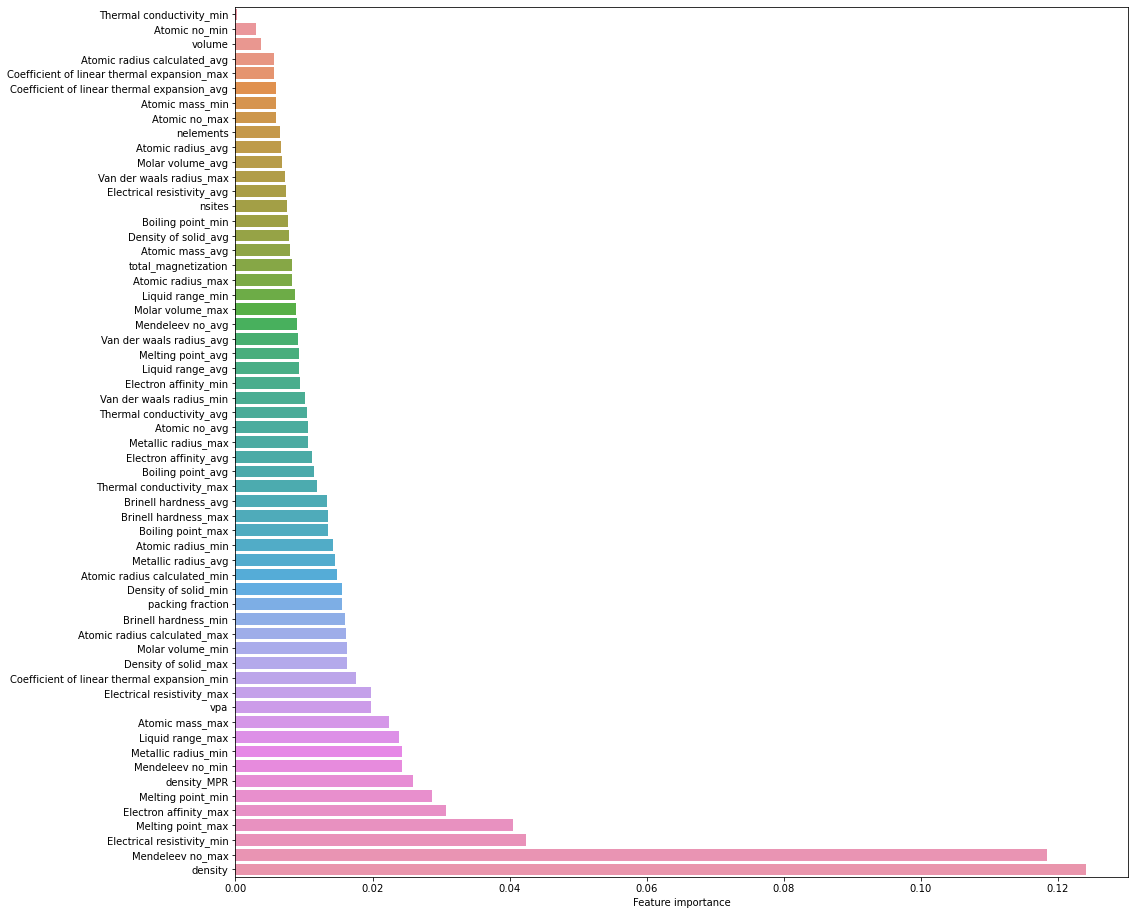

In [381]:
XGB_important = dict(zip(train_X.columns,xgb_model.feature_importances_))
#RF_importantdf = pd.DataFrame(RF_important)
sorted_features = sorted(XGB_important, key = XGB_important.get)
sorted_dict ={}
for key in sorted_features:
    sorted_dict[key]= XGB_important[key]
plt.subplots(figsize=(16, 16))
sns.barplot(list(sorted_dict.values()), list(sorted_dict.keys()), orient ="h")
plt.xlabel("Feature importance");

In [155]:

prediction_xgb =CV_xgb["estimator"][4].predict(Kaggle_X)
prediction_xgbdf = pd.DataFrame( final_test["material_id"])
prediction_xgbdf["dielectric_poly_total"] = prediction_xgb
prediction_xgbdf.to_csv("xgb_results.csv", index = False)

In [382]:
top_features = list(sorted_dict)[-30:]

In [383]:
X = final_train[top_features]
Y = final_train[["dielectric_poly_total_x"]]
Kaggle_X = final_test[top_features]
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.1)

In [384]:
reg_feat = xgboost.XGBRegressor(tree_method="gpu_hist")

CV_xgb_feat = cross_validate(reg_feat, train_X, train_y, cv =kfold, return_estimator = True)
rmse_xgb_feat = []
mae_xgb_feat = []
for i in CV_xgb_feat["estimator"]: 
    yhat_xgb = i.predict(test_X)
    rmse_xgb_feat.append(np.sqrt(metrics.mean_squared_error(test_y, yhat_xgb)))
    mae_xgb_feat.append(metrics.mean_absolute_error(test_y, yhat_xgb))
print(np.mean(mae_xgb_feat))
print(np.mean(rmse_xgb_feat))
mae_xgb_feat

5.293810091144741
8.986758631977832


[5.284274294877845,
 5.16437741295148,
 5.4635085952180775,
 5.208051624475084,
 5.348838528201225]

In [390]:
xgbmodel_feat = CV_xgb_feat["estimator"][1]

# By cutting down on our features and reducing our overfitting, we decreased our MAE by another 7%. 

In [388]:
list(sorted_dict)[-30:]

['Metallic radius_max',
 'Electron affinity_avg',
 'Boiling point_avg',
 'Thermal conductivity_max',
 'Brinell hardness_avg',
 'Brinell hardness_max',
 'Boiling point_max',
 'Atomic radius_min',
 'Metallic radius_avg',
 'Atomic radius calculated_min',
 'Density of solid_min',
 'packing fraction',
 'Brinell hardness_min',
 'Atomic radius calculated_max',
 'Molar volume_min',
 'Density of solid_max',
 'Coefficient of linear thermal expansion_min',
 'Electrical resistivity_max',
 'vpa',
 'Atomic mass_max',
 'Liquid range_max',
 'Metallic radius_min',
 'Mendeleev no_min',
 'density_MPR',
 'Melting point_min',
 'Electron affinity_max',
 'Melting point_max',
 'Electrical resistivity_min',
 'Mendeleev no_max',
 'density']

# Based on these findings, the strength of the bonds, electronegativity, and the structural density of the material are all influential factors on the total poly dielectric constant. 


For factors such as density and packing fraction and similar features, the increased ordering and its relationship with the dielectric constant can be potentially explained by the Clausius-Mosotti relation. The equation also includes the impact of polarizability has on the dielectric constant. This is particularly relevant to the Mendeleev Number which is derived from the element's atomic radius and electronegativity. Factors such as the atomic radii affect a material's polarizability which in turn affects the dielectric constant. Density and polarizability are variables that are relevant to the Clausius-Mosotti equation in that they are proportionally related to the dielectric constant.


Future steps would involve pursuing features related to the above variables. Additionally, we can tune the hyperparameters of the XGBoost model to find the optimal parameers 

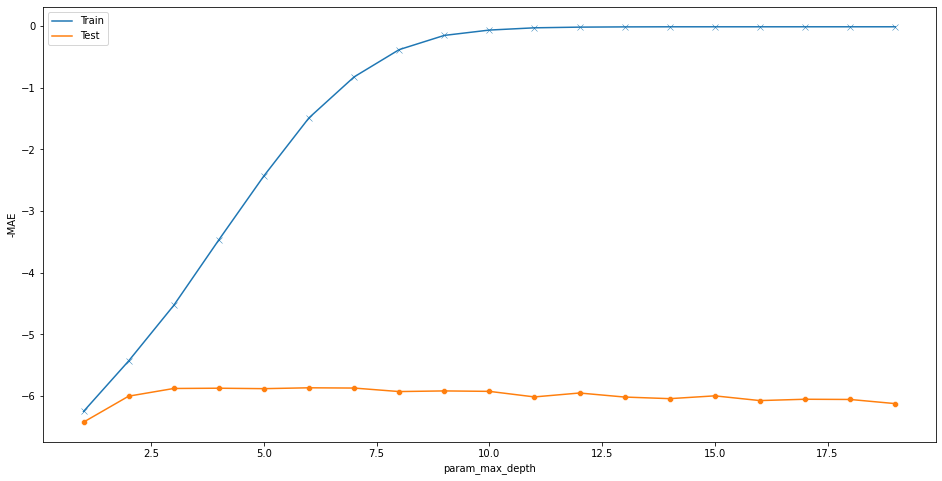

In [391]:
gs = GridSearchCV(
    xgbmodel_feat,
    param_grid={"max_depth": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    cv=kfold
)
gs.fit(train_X, train_y)
plot_grid_search_results(gs)
plt.ylabel("-MAE");

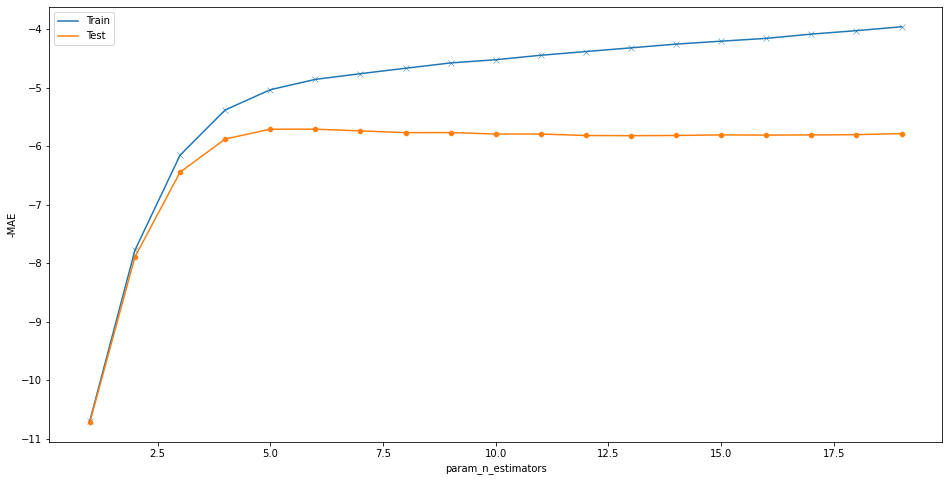

In [400]:
gs = GridSearchCV(
    xgbmodel_feat,
    param_grid={"n_estimators": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    cv=kfold
)
gs.fit(train_X, train_y)
plot_grid_search_results(gs)
plt.ylabel("-MAE");

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Ryan\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 182, in mean_absolute_error
    y_type, y_true, y_pre

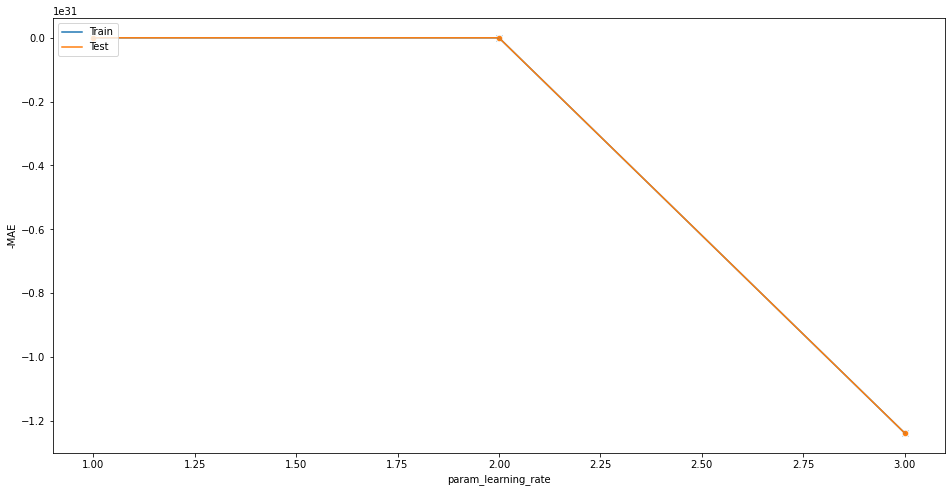

In [401]:
gs = GridSearchCV(
    xgbmodel_feat,
    param_grid={"learning_rate": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    cv=kfold
)
gs.fit(train_X, train_y)
plot_grid_search_results(gs)
plt.ylabel("-MAE");

In [394]:
prediction_xgbdf_feat = pd.DataFrame( final_test["material_id"])
prediction_xgbdf_feat["dielectric_poly_total"] = xgbmodel_feat.predict(Kaggle_X)


In [395]:
prediction_xgbdf_feat

,material_id,dielectric_poly_total
0,mp-1223893,19.334301
1,mp-16988,12.415579
2,mp-730,23.496134
3,mp-756202,10.370947
4,mp-580941,15.908970
...,...,...
1395,mp-34293,37.230106
1396,mp-752975,14.989589
1397,mp-8962,14.338047
1398,mp-20782,15.315440


In [397]:
prediction_xgbdf_feat.to_csv("xgboost_feat_results.csv", index= False)

In [405]:
reg_hyper = xgboost.XGBRegressor(max_depth =10, n_estimators =6)

CV_xgb_hyper = cross_validate(reg_hyper, train_X, train_y, cv =kfold, return_estimator = True)
rmse_xgb_hyper = []
mae_xgb_hyper = []
for i in CV_xgb_hyper["estimator"]: 
    yhat_xgb = i.predict(test_X)
    rmse_xgb_hyper.append(np.sqrt(metrics.mean_squared_error(test_y, yhat_xgb)))
    mae_xgb_hyper.append(metrics.mean_absolute_error(test_y, yhat_xgb))
print(np.mean(mae_xgb_hyper))
print(np.mean(rmse_xgb_hyper))
mae_xgb_hyper

5.151051567054642
9.633700029271637


[5.332859536085986,
 5.146603968074317,
 5.083145733462175,
 5.00163730001898,
 5.19101129763175]

# Tuning our hyperparameters gave us a marginal decrease in our MAE of about 2%. 



In [443]:
final_test

,volume,nsites,nelements,density_MPR,total_magnetization,unit_cell_formula,pretty_formula,material_id,Composition,Atomic mass_min,Atomic mass_max,Atomic mass_avg,Atomic no_min,Atomic no_max,Atomic no_avg,Atomic radius_min,Atomic radius_max,Atomic radius_avg,Atomic radius calculated_min,Atomic radius calculated_max,Atomic radius calculated_avg,Boiling point_min,Boiling point_max,Boiling point_avg,Brinell hardness_min,Brinell hardness_max,Brinell hardness_avg,Coefficient of linear thermal expansion_min,Coefficient of linear thermal expansion_max,Coefficient of linear thermal expansion_avg,Density of solid_min,Density of solid_max,Density of solid_avg,Electrical resistivity_min,Electrical resistivity_max,Electrical resistivity_avg,Liquid range_min,Liquid range_max,Liquid range_avg,Melting point_min,Melting point_max,Melting point_avg,Mendeleev no_min,Mendeleev no_max,Mendeleev no_avg,Molar volume_min,Molar volume_max,Molar volume_avg,Thermal conductivity_min,Thermal conductivity_max,Thermal conductivity_avg,Van der waals radius_min,Van der waals radius_max,Van der waals radius_avg,Metallic radius_min,Metallic radius_max,Metallic radius_avg,Electron affinity_min,Electron affinity_max,Electron affinity_avg,structure,density,vpa,packing fraction
0,192.921902,7,4,5.260498,8.000000e-07,"{'In': 1.0, 'Ag': 1.0, 'Ge': 1.0, 'Se': 4.0}",InAgGeSe4,mp-1223893,"(In, Ag, Ge, Se)",72.640000,114.81800,152.791550,32.0,49.0,66.000000,1.15,1.60,2.250000,1.03,1.65,2.145000,958.0,3093.0,2926.250000,2.0,736.0,744.500000,6.0,32.0,24.000000,4819.0,10490.0,10599.750000,1.0,50000.0,12512.250000,464.0,1915.0,1713.000000,429.0,1234.0,1212.500000,71.0,93.0,151.500000,10.0,16.0,25.500000,0.0,430.0,143.000000,1.90,2.11,3.437500,1.322111,1.670000,2.448361,0.383926,2.020605,2.750874,"[[0. 0. 5.568691] In, [2.942959 0...",5.260498,27.560272,0.344282
1,543.884152,24,4,4.228700,1.160440e-02,"{'Sr': 3.0, 'Cu': 6.0, 'Sn': 3.0, 'S': 12.0}",SrCu2SnS4,mp-16988,"(Sr, Cu, Sn, S)",32.065000,118.71000,346.261500,16.0,50.0,157.500000,1.00,2.00,7.612500,0.88,2.19,7.545000,717.0,3200.0,10348.500000,2.0,874.0,1356.750000,10.0,22.0,87.000000,1960.0,8920.0,26715.000000,1.0,13.0,49.500000,329.0,2369.0,5980.500000,388.0,1357.0,4365.750000,15.0,94.0,463.500000,7.0,33.0,92.250000,0.0,400.0,676.500000,1.80,2.49,11.835000,1.278000,2.151000,8.681583,0.052066,2.077105,8.958092,"[[ 1.78666417 3.0945929 12.9912298 ] Sr, [ 1...",4.228682,22.661939,0.461388
2,190.583786,12,2,8.957968,6.950000e-06,"{'P': 8.0, 'Pt': 4.0}",P2Pt,mp-730,"(P, Pt)",30.973762,195.08400,514.063048,15.0,78.0,216.000000,1.00,1.35,6.700000,0.98,1.77,7.460000,550.0,4098.0,10396.000000,2.0,392.0,792.000000,8.0,10.0,56.000000,1823.0,21090.0,49472.000000,10.0,10.0,60.000000,232.0,2056.0,5040.000000,317.0,2041.0,5350.000000,68.0,90.0,496.000000,9.0,17.0,86.000000,0.0,72.0,144.000000,1.80,2.13,11.460000,1.322111,1.387000,8.062444,0.746607,2.125105,7.236638,"[[2.24416239 2.24416239 2.24416239] P, [0.6332...",8.957968,15.881982,0.392134
3,839.325168,18,3,4.446308,3.631000e-04,"{'Ba': 4.0, 'Sr': 2.0, 'I': 12.0}",Ba2SrI6,mp-756202,"(Ba, Sr, I)",87.620000,137.32700,749.133880,38.0,56.0,312.000000,1.40,2.15,9.800000,1.15,2.53,9.433333,457.0,2143.0,5788.666667,2.0,2.0,12.000000,10.0,22.0,81.333333,2630.0,4940.0,26193.333333,10.0,34.0,94.000000,70.0,1143.0,2207.333333,386.0,1050.0,3577.333333,14.0,97.0,416.666667,25.0,38.0,172.666667,0.0,35.0,47.333333,1.98,2.68,13.153333,1.322111,2.236000,9.703778,0.052066,3.059052,12.463755,"[[0. 4.1486395 4.11204013] Ba, [0. ...",4.354529,47.611964,0.433444
4,294.954427,8,2,5.286907,4.025000e-06,"{'Ag': 4.0, 'I': 4.0}",AgI,mp-580941,"(Ag, I)",107.868200,126.90447,469.545340,47.0,53.0,200.000000,1.40,1.60,6.000000,1.15,1.65,5.600000,457.0,2435.0,5784.000000,2.0,24.0,52.000000,10.0,18.0,56.000000,4940.0,10490.0,30860.000000,1.0,10.0,22.000000,70.0,1200.0,2540.000000,386.0,1234.0,3240.000000,71.0,97.0,336.000000,10.0,25.0,70.000000,0.0,430.0,860.000000,1.98,2.11,8.180000,1.322111,1.445000,5.534222,1.